In [1]:
import os
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import numpy as np

import utils

In [2]:
%matplotlib inline

In [3]:
main_path = Path.cwd() / ".."

---

Cargamos las imagenes a usar en el ejercicio.

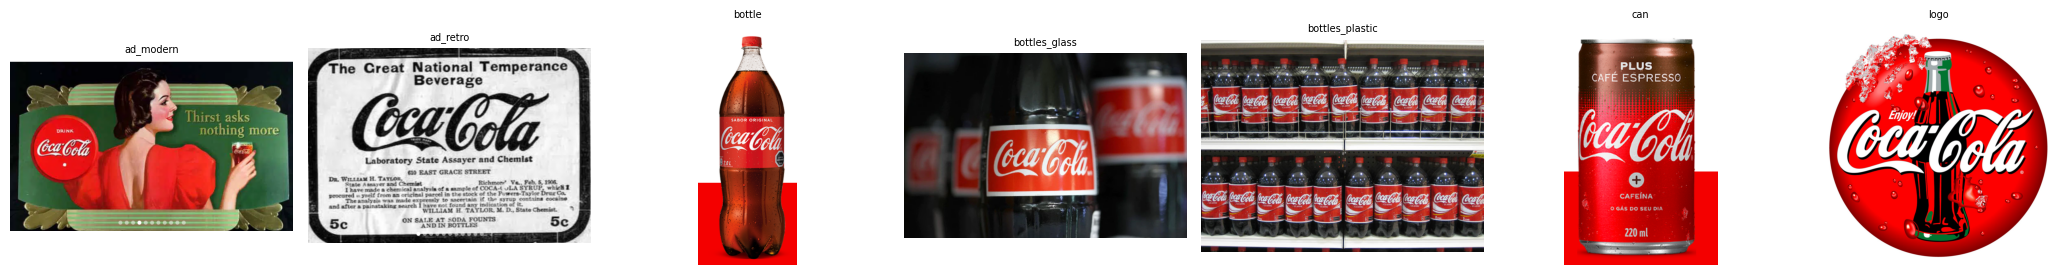

imgs shape:

ad_modern:        h_429, w_715
ad_retro:         h_493, w_715
bottle:           h_500, w_207
bottles_glass:    h_450, w_687
bottles_plastic:  h_598, w_799
can:              h_363, w_233
logo:             h_1389, w_1389


In [4]:
folder_path = main_path / "data/images"

dict_imgs = {}
for filename in os.listdir(folder_path):
    file_path = os.path.join(folder_path, filename)

    name, _ = os.path.splitext(filename)
    dict_imgs[name] = cv2.imread(file_path)

utils.plot_imgs(list(dict_imgs.values()), list(dict_imgs.keys()), rows=1, figsize=3)

print("imgs shape:\n")
for name, img in dict_imgs.items():
    blank = " "
    print(f"{name}:{blank*(16-len(name))} h_{img.shape[0]}, w_{img.shape[1]}")

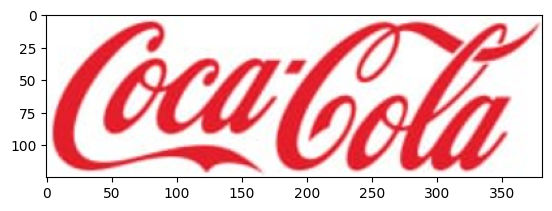

In [5]:
folder_path = main_path / "data/template"
filename = "logo_template.png"
file_path = os.path.join(folder_path, filename)

template = cv2.imread(file_path)

template_cropped = template[27:152,7:388,:]
plt.imshow(cv2.cvtColor(template_cropped, cv2.COLOR_BGR2RGB))

---

##### Ejercicio 1
Obtener una detección del logo en cada imagen sin falsos positivos.



Como podemos observar, los logos en las imágenes sobre las que vamos a buscar están en blanco sobre rojo o negro sobre blanco. Por lo cual un template con el logo en tono medio (rojo) sobre fondo blanco va a ser subóptimo para matchear.

Vamos a obtener los bordes de las imágenes y del template utilizando Canny. De esta manera vamos a poder matchear generalizando a nuevos casos en los que el logo aparezca sobre un fondo completamente diferente.

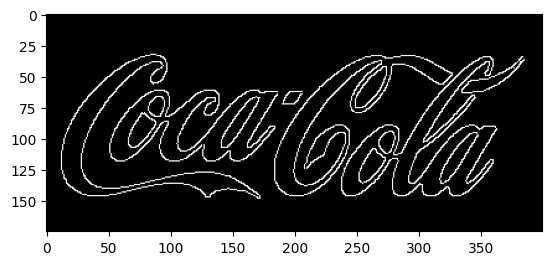

In [6]:
template_gray = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY)
template_border = cv2.Canny(template_gray, threshold1=5, threshold2=200)

plt.imshow(cv2.cvtColor(template_border, cv2.COLOR_BGR2RGB))

Encontramos además logos de diversos tamaños y proporciones (debido a la curvatura de los envases por ej.) en las imágenes sobre las que vamos a matchear. Por este motivo vamos a tener que generar múltiples templates variando la escala y la proporción para poder matchearlos.

logo menor: h_32, w_75
max scale: 3.906


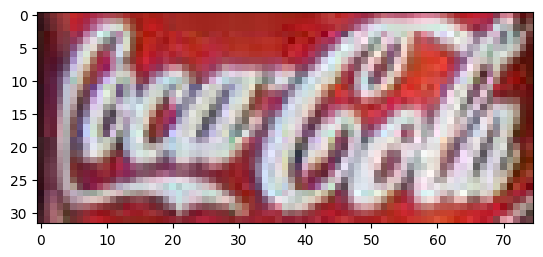

In [7]:
# Logo de menor encontrado en las imágenes
logo_menor = dict_imgs["bottles_plastic"][156:188, 115:190,:]

plt.imshow(cv2.cvtColor(logo_menor, cv2.COLOR_BGR2RGB))

print(f"logo menor: h_{logo_menor.shape[0]}, w_{logo_menor.shape[1]}")

# Compare height of the template vs the smallest logo
max_scale = round(template_cropped.shape[0] / logo_menor.shape[0], 3)
print(f"max scale: {max_scale}")

logo mayor: h_395, w_1155
min scale: 0.316


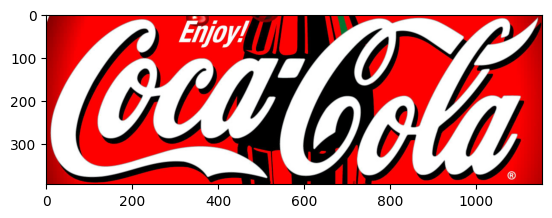

In [8]:
# Logo de mayor tamaño encontrado en las imágenes
logo_mayor = dict_imgs["logo"][475:870,95:1250,:]

plt.imshow(cv2.cvtColor(logo_mayor, cv2.COLOR_BGR2RGB))

print(f"logo mayor: h_{logo_mayor.shape[0]}, w_{logo_mayor.shape[1]}")

# Compare height of the template vs the biggest logo
min_scale = round(template_cropped.shape[0] / logo_mayor.shape[0], 3)
print(f"min scale: {min_scale}")

In [9]:
def get_scaled_imgs(img, scales):
    list_imgs = []
    for scale in scales:
        img_scaled = cv2.resize(img, None, fx=scale, fy=scale)

        list_imgs.append(img_scaled)

    return list_imgs

In [10]:
def get_image_border(img):
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_gray = cv2.GaussianBlur(img_gray, ksize=(3,3), sigmaX=1, sigmaY=1)
    img_border = cv2.Canny(img_gray, threshold1=5, threshold2=200)

    return(img_border)

In [11]:
def is_template_too_big(template, img):
    template_too_tall = template.shape[0] > img.shape[0]
    template_too_wide = template.shape[1] > img.shape[1]

    return template_too_tall | template_too_wide

In [12]:
def single_match(template, img, method, min_scale=1, max_scale=1, n_scales=1):
    method = eval(method)
    scales = np.linspace(max_scale, min_scale, n_scales)

    list_imgs = get_scaled_imgs(img=img, scales=scales)

    best_val = 0
    for scale, img in zip(scales, list_imgs):
        if is_template_too_big(template, img):
            break

        img_border = get_image_border(img)
        match = cv2.matchTemplate(img_border, template, method)
        _, max_val, _, top_left = cv2.minMaxLoc(match)

        if max_val > best_val:
            best_val = max_val

            bottom_right = (top_left[0] + template.shape[1], top_left[1] + template.shape[0])
            bbox_scaled = np.array(
                [top_left[0], top_left[1], bottom_right[0], bottom_right[1]]
            )

            best_bbox = (bbox_scaled / scale).astype(int)

    return np.hstack((best_bbox, best_val))

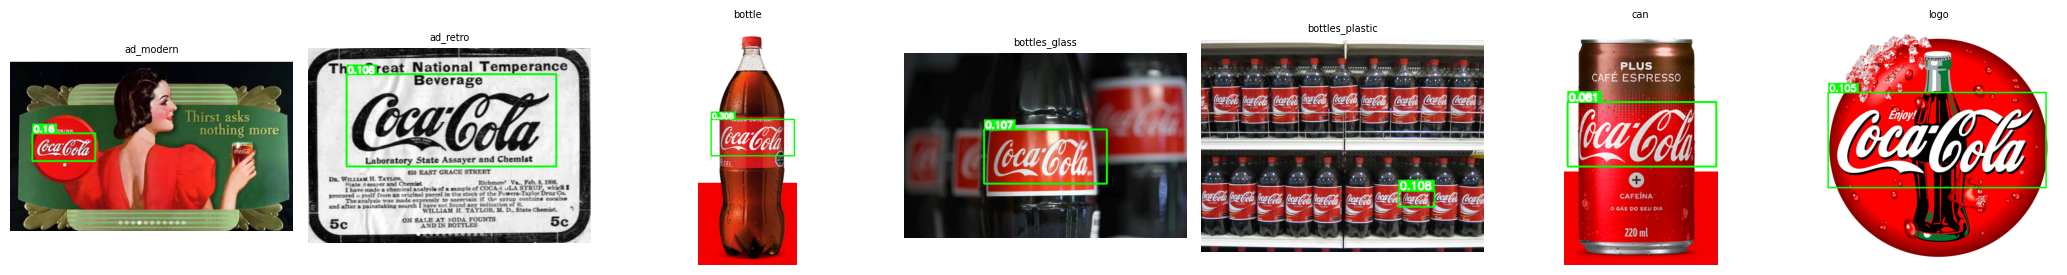

In [13]:
method = "cv2.TM_CCOEFF_NORMED"

list_annotated_imgs = []
for img in dict_imgs.values():
    match = single_match(
        template=template_border,
        img=img,
        method=method,
        min_scale=min_scale,
        max_scale=max_scale,
        n_scales=50
    )

    annotated_img = img.copy()
    utils.annotate_img(annotated_img, match[:4].astype(int), str(round(match[4],3)))

    list_annotated_imgs.append(annotated_img)

utils.plot_imgs(list_annotated_imgs, list(dict_imgs.keys()), rows=1, figsize=3)

---

##### Ejercicio 2
Plantear y validar un algoritmo para múltiples detecciones en la imagen coca_multi.png con el mismo template del ítem 1.

In [14]:
def multi_match(
    template,
    img,
    method,
    min_scale=1,
    max_scale=1,
    n_scales=1,
    threshold=0.9,
    iou_threshold=0.5,
):
    method = eval(method)
    scales = np.linspace(max_scale, min_scale, n_scales)

    list_imgs = get_scaled_imgs(img=img, scales=scales)

    max_val = 0
    matches = np.zeros((1, 5))
    for scale, img in zip(scales, list_imgs):
        if is_template_too_big(template, img):
            break

        img_border = get_image_border(img)
        res = cv2.matchTemplate(img_border, template, method)

        max_val_img = np.max(res)
        max_val = max_val_img if max_val_img > max_val else max_val
        keep = res > (threshold * max_val)
        if not np.sum(keep):
            continue

        top_lefts = np.array([[x, y] for y, x in zip(*np.where(keep))])
        bottom_rights = top_lefts + np.array([template.shape[1], template.shape[0]])
        bboxes_img_scaled = np.hstack((top_lefts, bottom_rights))
        bboxes_img = (bboxes_img_scaled / scale).astype(int)

        vals_img = np.array([[val] for val in res[keep].flatten()])

        matches_img = np.hstack((bboxes_img, vals_img))
        
        matches = np.vstack((matches, matches_img))
     
        keep = matches[:, 4] > (threshold * max_val)
        matches = matches[keep.flatten()]

        # Filter in each iteration to avoid 'out of memory' error.
        matches = utils.non_max_suppression(matches=matches, iou_threshold=iou_threshold)

    return matches

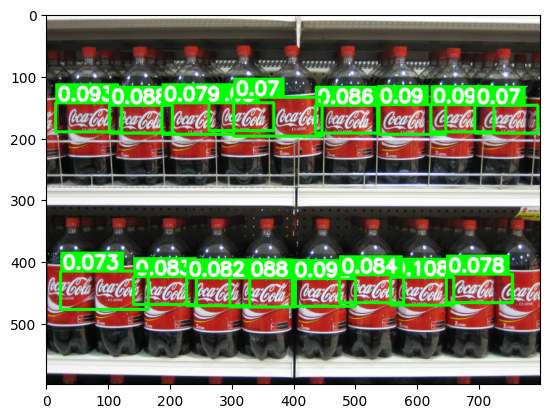

In [15]:
method = "cv2.TM_CCOEFF_NORMED"
img_name = "bottles_plastic"

matches = multi_match(
    template=template_border,
    img=dict_imgs[img_name],
    method=method,
    min_scale=min_scale,
    max_scale=max_scale,
    n_scales=50,
    threshold=0.6,
    iou_threshold=0.3,
)

img_annotated = dict_imgs[img_name].copy()
for match in matches:
    utils.annotate_img(img_annotated, match[:4].astype(int), str(round(match[4],3)))

plt.imshow(img_annotated[:,:,::-1])

Buscar en una sola imagen nos permite ser precisos con la definición del threshold para filtrar los matcheos.

---

##### Ejercicio 3
Generalizar este algoritmo para todas las imágenes.

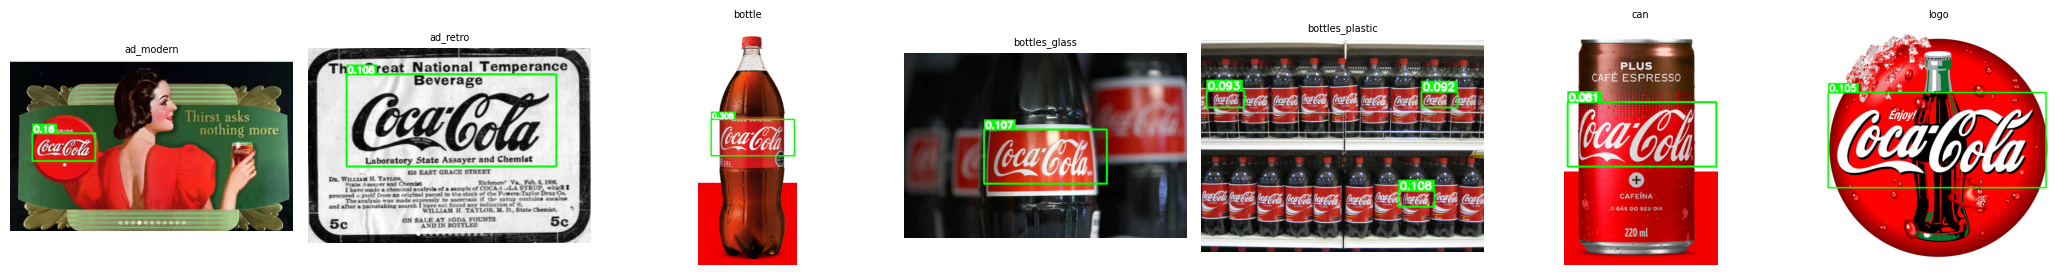

In [16]:
method = "cv2.TM_CCOEFF_NORMED"

list_annotated_imgs = []
for img_name in dict_imgs.keys():

    matches = multi_match(
        template=template_border,
        img=dict_imgs[img_name],
        method=method,
        min_scale=min_scale,
        max_scale=max_scale,
        n_scales=50,
        threshold=0.85,
        iou_threshold=0.3,
    )

    img_annotated = dict_imgs[img_name].copy()
    for match in matches:
        utils.annotate_img(img_annotated, match[:4].astype(int), str(round(match[4],3)))

    list_annotated_imgs.append(img_annotated)

utils.plot_imgs(list_annotated_imgs, list(dict_imgs.keys()), rows=1, figsize=3)

Al generalizar el algoritmo debemos definir un threshold más alto para evitar falsos positivos en todas las imágenes. Esto genera que tengamos menor precisión de matcheo en la imagen de botellas múltiples que la obtenida al buscar en sólo esa imagen.

---

##### Conclusiones
Cuando se desea matchear el template con imágenes variadas, ya sea por iluminación, contraste, y principalmente con el objeto a matchear en escalas muy diferentes, el algoritmo de template matching no es el mejor. Sin embargo, en este trabajo puede notarse que, con una rápida pre-producción de las imágenes, este algoritmo demuestra una gran performance en relación al escaso cómputo requerido (debido a su no necesidad de entrenamiento y su rápidez en el matcheo de objetos).

Sin lugar a dudas, el fuerte del algoritmo está en batch de imágenes en las cuales el objeto a matchear tiene carácterísticas similares en todas ellas.